In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -qq ./drive/My\ Drive/twitter_sentiment.zip

In [3]:
!pip install urllib3==1.25.9

!pip install transformers==2.8.0

     |████████████████████████████████| 133kB 20.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
     |████████████████████████████████| 573kB 17.6MB/s 
     |████████████████████████████████| 1.1MB 50.4MB/s 
     |████████████████████████████████| 3.7MB 50.8MB/s 
     |████████████████████████████████| 133kB 55.5MB/s 
     |████████████████████████████████| 890kB 35.5MB/s 
     |████████████████████████████████| 7.1MB 50.0MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4492074be1b868cbde16c9a940d4b90512c9a65213edf58c6c6b8339a287194c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import csv
import os

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import defaultdict
from pylab import rcParams
from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import re

In [5]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 8, 5

In [6]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [7]:
class sentiment_analysis(Dataset):

    def __init__(self, csv_file, mode,tokenizer):

        
        self.mode = mode
        self.tokenizer = tokenizer
      
        df = pd.read_csv(csv_file)

        # Function to clean text. Remove tagged entities, hyperlinks, emojis
        def clean_text(text):
            text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
            text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
            text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
            text = re.sub('\t', ' ',  text)
            text = re.sub(r" +", ' ', text)
            return text
        
        df['review'] = df['text'].apply(clean_text)

        self.reviews = df['text'].to_numpy()

        if mode != 'test':
          self.targets = df['sentiment_label'].to_numpy()

        self.token = []

        for txt in df.review:
          tokens = tokenizer.encode(txt, max_length=512)
          self.token.append(len(tokens))
        

    
    def tokenizer_len(self):#找出最大的tokenizer_len
        self.token_lens =max(self.token)+30
        return (self.token_lens)

    def tolenizer_distribute(self):#畫出最大的tokenizer_len的分配

        sns.distplot(self.token_lens)
        plt.xlim([0, 256]);
        plt.xlabel('Token count');plt.show()
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=100,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=100, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=100, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        if self.mode!='test':
          target = self.targets[item]

          return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target)
          }
        else:
          return{      
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()}

In [8]:
dataset_train=sentiment_analysis ('./twitter_sentiment/train.csv','train', tokenizer)
dataset_val=sentiment_analysis('./twitter_sentiment/val.csv', 'val',tokenizer)
dataset_test=sentiment_analysis('./twitter_sentiment/test.csv','test',tokenizer)

In [9]:
BATCH_SIZE=8

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
data1 = next(iter(test_loader))
data1.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask'])

90


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


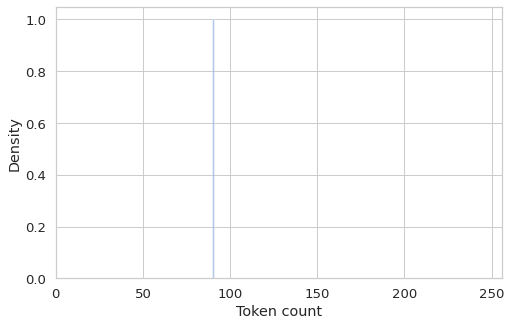

In [11]:
print(dataset_train.tokenizer_len())
dataset_train.tolenizer_distribute()

In [ ]:
# max_len=dataset_train.tokenizer_len()

In [ ]:
# XLNet_model = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
# class SentimentClassifier(nn.Module):

#   def __init__(self, n_classes):
#     super(SentimentClassifier, self).__init__()
#     self.XLNet =  XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.drop = nn.Dropout(p=0.3)
#     self.out = nn.Linear(self.XLNet.config.hidden_size, n_classes)
  
#   def forward(self, input_ids, attention_mask):
#     _, pooled_output = self.XLNet(
#       input_ids=input_ids,
#       attention_mask=attention_mask
#     )
#     output = self.drop(pooled_output)
#     return self.out(output)

In [ ]:
# model = SentimentClassifier(3)#共有3類(正,中,負)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = model.to(device)

In [11]:
from transformers import XLNetForSequenceClassification

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 3)
model = model.to(device)


In [12]:
EPOCHS = 5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)


In [13]:
def train_epoch(model,data_loader,loss_fn, optimizer,scheduler):  
 
  model = model.train()

  losses = []
  correct_predictions = 0
  total_count=0
  for d in data_loader:
    input_ids = d["input_ids"].reshape(BATCH_SIZE,100).to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask, labels = targets)
    
    _, preds =torch.max(outputs[1], dim=1)
    # _, preds = torch.max(outputs.data, dim=1)
    loss = outputs[0]
    # loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    total_count +=len(attention_mask)

  return correct_predictions.double() / total_count, np.mean(losses)

In [14]:
def eval_model(model, data_loader, loss_fn):
  model = model.eval()

  losses = []
  correct_predictions = 0
  total_count=0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].reshape(BATCH_SIZE,100).to(device)      
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, labels = targets)
     
      _, preds =torch.max(outputs[1], dim=1)

      # loss = loss_fn(outputs, targets)
      loss = outputs[0]

      correct_predictions += torch.sum(preds == targets)
      # correct_predictions +=(preds==targets).sum().item()
      losses.append(loss.item())
      total_count +=len(attention_mask)

  return correct_predictions.double() / total_count, np.mean(losses)

In [15]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,train_loader,
                                      loss_fn,optimizer,scheduler)
    
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_loader,loss_fn)
    
    
  print(f'Val loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:#儲存最好的模型
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss 0.5318699169767312 accuracy 0.7906908665105387
Val loss 0.41550718754774235 accuracy 0.8463114754098361
Epoch 2/5
----------
Train loss 0.4007605389763865 accuracy 0.8650468384074942
Val loss 0.49170931597377676 accuracy 0.8497267759562841
Epoch 3/5
----------
Train loss 0.3326180866494328 accuracy 0.9002732240437158
Val loss 0.6284957026001676 accuracy 0.8504098360655737
Epoch 4/5
----------
Train loss 0.2808332815122915 accuracy 0.9240827478532396
Val loss 0.7272817787442031 accuracy 0.8469945355191257
Epoch 5/5
----------
Train loss 0.24311114337636452 accuracy 0.9383294301327089
Val loss 0.7808042523653763 accuracy 0.8565573770491803


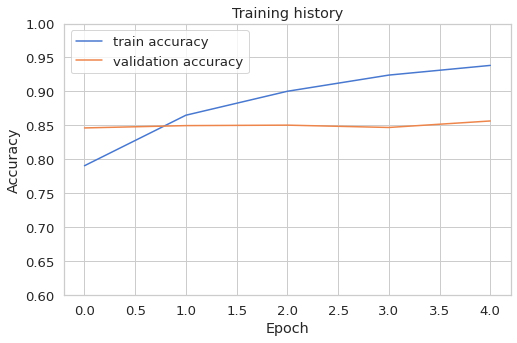

In [16]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1]);

In [17]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].reshape(BATCH_SIZE,100).to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask)
      
      _, preds = torch.max(outputs[0], dim=1)

      predictions.extend(preds.to('cpu').numpy().tolist())

  return predictions

In [ ]:
y_pred = get_predictions(model,test_loader)
  
y_pred

In [19]:
idx = 0
with open('sentiment_analysis.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['index', 'sentiment_label'])
    writer.writeheader()
    for result in y_pred:
        writer.writerow({'index':idx, 'sentiment_label':result})
        idx+=1

In [20]:
from google.colab import files
files.download("sentiment_analysis.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>